### Training


In [49]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import f1_score
import tensorflow as tf
import seaborn as sn
import librosa
import math
import random


In [2]:
DATA_PATH = "data.json"

VAL_SIZE = 0.2
TEST_SIZE = 0.1


In [36]:
# load training data from json file

with open(DATA_PATH, "r") as f:
    data = json.load(f)

X = np.array(data["mfcc"])
y = np.array(data["labels"])


In [37]:
# split data into train, validation and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=VAL_SIZE)

# add an axis to input sets to match the shape CNN expects (last axis is like channel in color images)
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]
X_validation = X_validation[..., np.newaxis]


In [29]:

norm_X_train = tf.keras.utils.normalize(X_train)
norm_X_validation = tf.keras.utils.normalize(X_validation)

In [54]:
# build model

class F1ScoreCallback(Callback):
    def __init__(self, validation_data=()):
        super(Callback, self).__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs={}):
        x_val, y_val = self.validation_data
        y_pred = np.argmax(self.model.predict(x_val), axis=1)
        y_true = np.argmax(y_val)
        y_true = np.array(y_true)
        f1 = f1_score(y_true, y_pred, average='weighted')
        print(f' - val_f1_score: {f1:.4f}')
        logs['val_f1_score'] = f1

model = keras.Sequential()

# 1st conv layer
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)))
model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model.add(keras.layers.BatchNormalization())

# 2nd conv layer
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model.add(keras.layers.BatchNormalization())

# 3rd conv layer
model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
model.add(keras.layers.BatchNormalization())

# flatten output and feed it into dense layer
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(0.3))

# output layer
model.add(keras.layers.Dense(10, activation='softmax'))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 429, 11, 32)       320       
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 215, 6, 32)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_33 (Ba  (None, 215, 6, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_34 (Conv2D)          (None, 213, 4, 32)        9248      
                                                                 
 max_pooling2d_34 (MaxPooli  (None, 107, 2, 32)        0         
 ng2D)                                                           
                                                     

In [55]:
# train model
# y_train_one_hot = to_categorical(y_train, num_classes=10)
# y_train = tf.cast(y_train, tf.float64)
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30, callbacks=[F1ScoreCallback(validation_data=(X_validation, y_validation))])

Epoch 1/30
53/53 [==============================] - 0s 3ms/step loss: 2.3973 - accuracy


TypeError: Singleton array array(20) cannot be considered a valid collection.

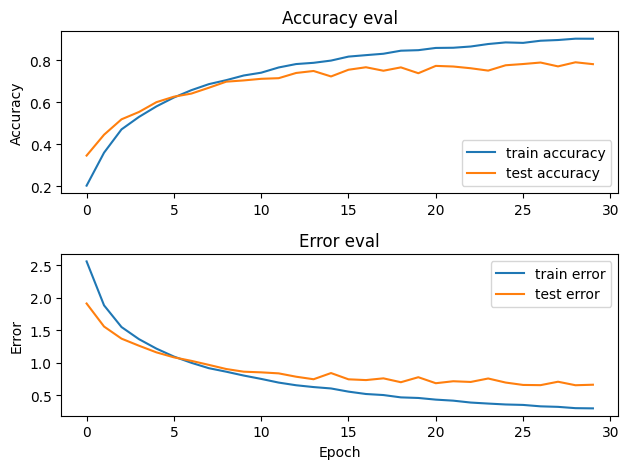

In [10]:
# plot accuracy/error for training and validation

fig, axs = plt.subplots(2)

# create accuracy subplot
axs[0].plot(history.history["accuracy"], label="train accuracy")
axs[0].plot(history.history["val_accuracy"], label="test accuracy")
axs[0].set_ylabel("Accuracy")
axs[0].legend(loc="lower right")
axs[0].set_title("Accuracy eval")

# create error subplot
axs[1].plot(history.history["loss"], label="train error")
axs[1].plot(history.history["val_loss"], label="test error")
axs[1].set_ylabel("Error")
axs[1].set_xlabel("Epoch")
axs[1].legend(loc="upper right")
axs[1].set_title("Error eval")

fig.tight_layout()
plt.show()


In [11]:
# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc}")


30/30 - 1s - loss: 0.6609 - accuracy: 0.7894 - 602ms/epoch - 20ms/step
Test accuracy: 0.7893617153167725


30/30 [==============================] - 0s 7ms/step
tf.Tensor(
[[62  6  3  1  8  1  2  1  0  1]
 [ 0 90  0  0  3  0  0  1  1  0]
 [ 1  0 88  0  0  1  2  3  1  2]
 [ 0  0  2 83  7  1  0  0  0  0]
 [ 2  1  0  1 84  3  1  1  0  1]
 [ 2  3  0  2  0 63  1  3  4  1]
 [ 4  1  7  0  0  3 64 10  0 11]
 [ 4  3  3  0  0  5  1 75  7  5]
 [ 5  0  4  1  1 15  1 12 63  4]
 [ 2  2  2  2  0  3  1  3  2 70]], shape=(10, 10), dtype=int32)
[ 85  95  98  93  94  79 100 103 106  87]


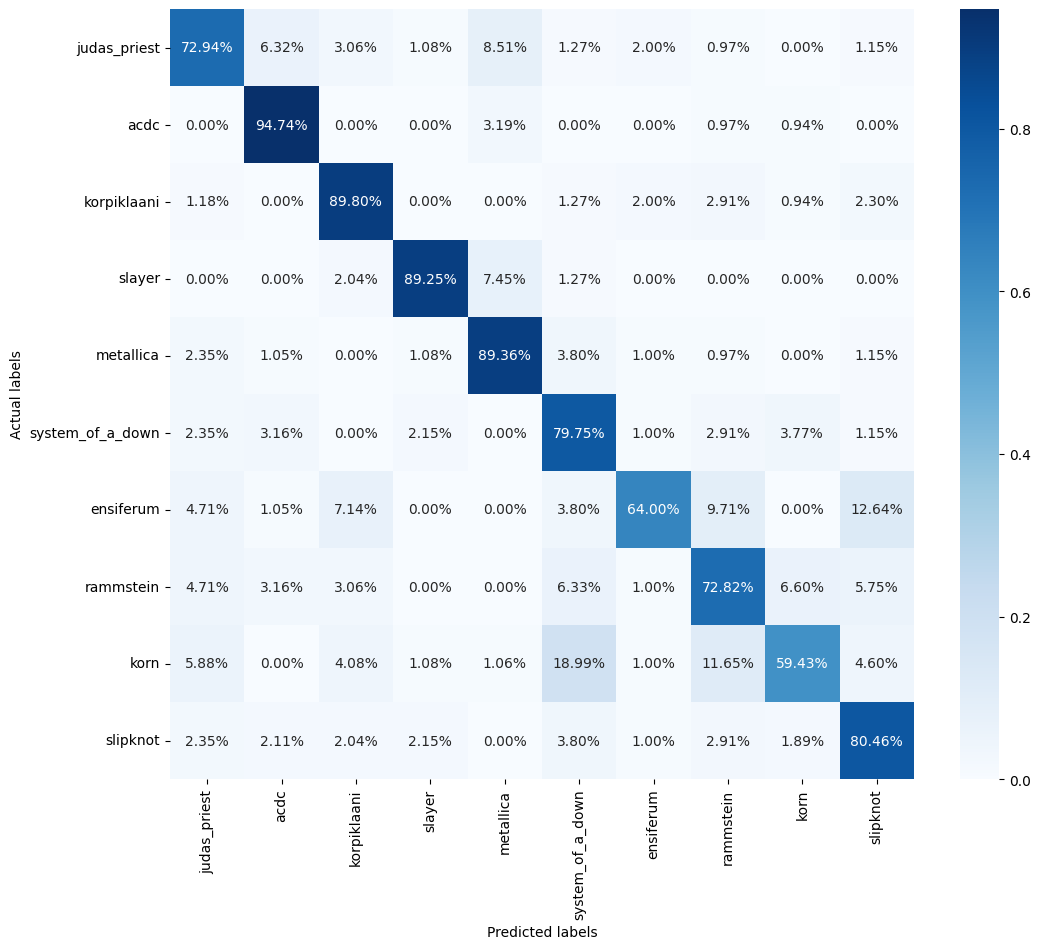

In [12]:
predictions = model.predict(X_test)
#predictions[i] = predicted_index
pred_argmax = []

for i in range(len(predictions)):
    predicted_index = np.argmax(predictions[i])
    pred_argmax.append(predicted_index)

conf_matrix = tf.math.confusion_matrix(labels=y_test, predictions=pred_argmax)
print(conf_matrix)

cat = data["mapping"]
fig, ax = plt.subplots(figsize=(12,10), facecolor='white')
#sn.heatmap(conf_matrix, annot=True, fmt='', xticklabels=cat, yticklabels=cat, cmap='Blues')
sn.heatmap(conf_matrix/np.sum(conf_matrix, axis=1), annot=True, fmt='.2%', xticklabels=cat, yticklabels=cat, cmap='Blues')
ax.set(xlabel="Predicted labels", ylabel="Actual labels")

print(np.sum(conf_matrix, axis=1))

In [18]:
# pick a sample to predict from the test set
X_to_predict = X_test[901]
y_to_predict = y_test[901]

# predict sample

# add a dimension to input data for sample - model.predict() expects a 4d array in this case
X_to_predict = X_to_predict[np.newaxis, ...]
print(X_to_predict.shape)
print(y_to_predict.shape)
print(X_to_predict)
# perform prediction
prediction = model.predict(X_to_predict)

# get index with max value
predicted_index = np.argmax(prediction, axis=1)
print(cat)
print(f"Target: {y_to_predict}, Predicted label: {predicted_index}")

(1, 431, 13, 1)
()
[[[[ 20.86606598]
   [ 49.20656586]
   [ -9.20479679]
   ...
   [  0.69813353]
   [  0.18781051]
   [ -3.43413091]]

  [[ 50.95881653]
   [ 49.83117676]
   [ -8.51249123]
   ...
   [ -0.14899302]
   [  2.25691724]
   [ -4.39807701]]

  [[ 45.9458313 ]
   [ 48.19244766]
   [-11.33257103]
   ...
   [  2.69226408]
   [  4.68699074]
   [ -6.00588179]]

  ...

  [[ 53.92720032]
   [ 54.21590424]
   [-10.858078  ]
   ...
   [ -4.69635201]
   [  5.77329922]
   [ -3.32559514]]

  [[ 54.58085632]
   [ 54.31608582]
   [-10.96625328]
   ...
   [ -0.72691613]
   [  3.06780291]
   [ -7.41318321]]

  [[ 47.96729279]
   [ 53.86654282]
   [ -7.40162754]
   ...
   [ -3.55161095]
   [ -1.58250344]
   [ -9.57205963]]]]
1/1 [==============================] - 0s 18ms/step
['judas_priest', 'acdc', 'korpiklaani', 'slayer', 'metallica', 'system_of_a_down', 'ensiferum', 'rammstein', 'korn', 'slipknot']
Target: 6, Predicted label: [7]


In [24]:
# test model by picking specific song

SEGMENT_DURATION = 10 # in seconds
NUM_SEGMENTS_PER_TRACK = 20

n_mfcc=13
n_fft=2048
hop_length=512

SONG_PATH = "dataset/ensiferum/ensiferum-heathen_horde.mp3"

song_data = {
    "mfcc": [], # training inputs
    "labels": [] # outputs, targets
}

print("Predicting artist...")
signal, sr = librosa.load(SONG_PATH) # signal, sr = librosa.load(track_path, sr=None)
track_duration = librosa.get_duration(y=signal, sr=sr, n_fft=n_fft, hop_length=hop_length) # in seconds

num_samples = int(sr * track_duration)
num_samples_in_segment = int(sr * SEGMENT_DURATION)
expected_num_mfcc_vectors_in_segment = math.ceil(num_samples_in_segment / hop_length)

# choose start point
segment_start = random.randint(0, num_samples)
# calculate end point
segment_end = segment_start + num_samples_in_segment
if segment_end > num_samples:
    segment_start = segment_start - num_samples_in_segment
    segment_end = segment_end - num_samples_in_segment

# get mfcc from that segment
mfcc = librosa.feature.mfcc(y=signal[segment_start:segment_end], sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
mfcc = mfcc.T
# save results
# check expected length
if len(mfcc) == expected_num_mfcc_vectors_in_segment:
    song_data["mfcc"].append(mfcc.tolist()) #np array -> list

    path_components = SONG_PATH.split("/")
    artist = path_components[1]
    artist_idx = data["mapping"].index(artist)
    song_data["labels"].append(artist_idx)
    # print(f"{i-1} {j} {k} {track_path.split('/')[2]}, start: {segment_start}, end: {segment_end}, length: {segment_end - segment_start}")
else:
    print("length does not match expected!")

X_song = np.array(song_data["mfcc"])
y_song = np.array(song_data["labels"])[0]

X_song = X_song[..., np.newaxis]

# perform prediction
song_prediction = model.predict(X_song)

# get index with max value
song_predicted_index = np.argmax(song_prediction)

print(f"Target artist: {cat[y_song]}")
print(f"Predicted artist: {cat[song_predicted_index]}")
if y_song == song_predicted_index:
    print("Success!")
else:
    print("Incorrect :(")

Predicting artist...


[src/libmpg123/id3.c:process_comment():584] error: No comment text / valid description?


1/1 [==============================] - 0s 26ms/step
Target artist: ensiferum
Predicted artist: ensiferum
Success!
